<a href="https://colab.research.google.com/github/andrewwhite5/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
drinks = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv')

In [29]:
print(drinks.shape)

(193, 5)


In [30]:
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [34]:
drinks.columns

Index(['country', 'beer_servings', 'spirit_servings', 'wine_servings',
       'total_litres_of_pure_alcohol'],
      dtype='object')

In [35]:
drinks.sort_values('beer_servings', ascending=False).head(10)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
117,Namibia,376,3,1,6.8
45,Czech Republic,361,170,134,11.8
62,Gabon,347,98,59,8.9
65,Germany,346,117,175,11.3
98,Lithuania,343,244,56,12.9
135,Poland,343,215,56,10.9
188,Venezuela,333,100,3,7.7
81,Ireland,313,118,165,11.4
129,Palau,306,63,23,6.9
140,Romania,297,122,167,10.4


In [36]:
drinks.sort_values('wine_servings', ascending=False)[:10]  # This does the exact same thing as above (using ".head(10)")

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
61,France,127,151,370,11.8
136,Portugal,194,67,339,11.0
3,Andorra,245,138,312,12.4
166,Switzerland,185,100,280,10.2
48,Denmark,224,81,278,10.4
156,Slovenia,270,51,276,10.6
99,Luxembourg,236,133,271,11.4
42,Croatia,230,87,254,10.2
83,Italy,85,42,237,6.5
55,Equatorial Guinea,92,0,233,5.8


In [37]:
!ls

all.csv  sample_data


In [38]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [78]:
# drinks['drinks_alcohol'] = drinks['total_litres_of_pure_alcohol'] > 0
drinks['drinks_alcohol'] = np.where(drinks['total_litres_of_pure_alcohol'] > 0, 'Yes', 'No')
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol
0,Afghanistan,0,0,0,0.0,No
1,Albania,89,132,54,4.9,Yes
2,Algeria,25,0,14,0.7,Yes
3,Andorra,245,138,312,12.4,Yes
4,Angola,217,57,45,5.9,Yes


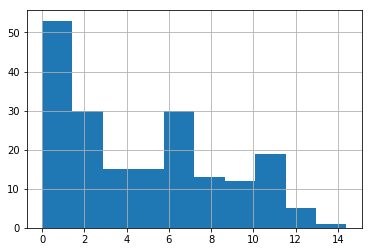

In [40]:
drinks.total_litres_of_pure_alcohol.hist()
plt.show()

In [79]:
drinks['drinks_alcohol'] = np.where(drinks['total_litres_of_pure_alcohol'] > 9, 'High',
                           np.where(drinks['total_litres_of_pure_alcohol'] >= 6, 'Medium',
                           np.where(drinks['total_litres_of_pure_alcohol'] == 0, 'None', 'Low')))
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol
0,Afghanistan,0,0,0,0.0,None
1,Albania,89,132,54,4.9,Low
2,Algeria,25,0,14,0.7,Low
3,Andorra,245,138,312,12.4,High
4,Angola,217,57,45,5.9,Low


In [43]:
drinks.drinks_alcohol.value_counts()

Low       105
Medium     41
High       34
None       13
Name: drinks_alcohol, dtype: int64

In [0]:
countries = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')

# Another way to bring it in:
# !wget https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv

In [45]:
print(countries.shape)

countries.head()

(249, 11)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [52]:
countries[['name','region','sub-region']].head()

,name,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [58]:
df = drinks.join(countries[['name','region','sub-region']], how='left')  # Obviously, this doesn't work -- just appended the first 193 rows
df.head(20)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
0,Afghanistan,0,0,0,0.0,None,Afghanistan,Asia,Southern Asia
1,Albania,89,132,54,4.9,Low,Åland Islands,Europe,Northern Europe
2,Algeria,25,0,14,0.7,Low,Albania,Europe,Southern Europe
3,Andorra,245,138,312,12.4,High,Algeria,Africa,Northern Africa
4,Angola,217,57,45,5.9,Low,American Samoa,Oceania,Polynesia
5,Antigua & Barbuda,102,128,45,4.9,Low,Andorra,Europe,Southern Europe
6,Argentina,193,25,221,8.3,Medium,Angola,Africa,Sub-Saharan Africa
7,Armenia,21,179,11,3.8,Low,Anguilla,Americas,Latin America and the Caribbean
8,Australia,261,72,212,10.4,High,Antarctica,NaN,NaN
9,Austria,279,75,191,9.7,High,Antigua and Barbuda,Americas,Latin America and the Caribbean


In [81]:
df = pd.merge(drinks, countries[['name','region','sub-region']], how='left', left_on='country', right_on='name')
print(df.shape)
df.head(10)

(193, 9)


,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
0,Afghanistan,0,0,0,0.0,None,Afghanistan,Asia,Southern Asia
1,Albania,89,132,54,4.9,Low,Albania,Europe,Southern Europe
2,Algeria,25,0,14,0.7,Low,Algeria,Africa,Northern Africa
3,Andorra,245,138,312,12.4,High,Andorra,Europe,Southern Europe
4,Angola,217,57,45,5.9,Low,Angola,Africa,Sub-Saharan Africa
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
6,Argentina,193,25,221,8.3,Medium,Argentina,Americas,Latin America and the Caribbean
7,Armenia,21,179,11,3.8,Low,Armenia,Asia,Western Asia
8,Australia,261,72,212,10.4,High,Australia,Oceania,Australia and New Zealand
9,Austria,279,75,191,9.7,High,Austria,Europe,Western Europe


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 9 columns):
country                         193 non-null object
beer_servings                   193 non-null int64
spirit_servings                 193 non-null int64
wine_servings                   193 non-null int64
total_litres_of_pure_alcohol    193 non-null float64
drinks_alcohol                  193 non-null object
name                            167 non-null object
region                          167 non-null object
sub-region                      167 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 15.1+ KB


In [83]:
df.isnull().sum()

country                          0
beer_servings                    0
spirit_servings                  0
wine_servings                    0
total_litres_of_pure_alcohol     0
drinks_alcohol                   0
name                            26
region                          26
sub-region                      26
dtype: int64

In [84]:
df[df.total_litres_of_pure_alcohol > 5].head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
3,Andorra,245,138,312,12.4,High,Andorra,Europe,Southern Europe
4,Angola,217,57,45,5.9,Low,Angola,Africa,Sub-Saharan Africa
6,Argentina,193,25,221,8.3,Medium,Argentina,Americas,Latin America and the Caribbean
8,Australia,261,72,212,10.4,High,Australia,Oceania,Australia and New Zealand
9,Austria,279,75,191,9.7,High,Austria,Europe,Western Europe


In [85]:
df[df.region.isna()]

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
20,Bolivia,167,41,8,3.8,Low,NaN,NaN,NaN
21,Bosnia-Herzegovina,76,173,8,4.6,Low,NaN,NaN,NaN
24,Brunei,31,2,1,0.6,Low,NaN,NaN,NaN
28,Cote d'Ivoire,37,1,7,4.0,Low,NaN,NaN,NaN
45,Czech Republic,361,170,134,11.8,High,NaN,NaN,NaN
46,North Korea,0,0,0,0.0,None,NaN,NaN,NaN
47,DR Congo,32,3,1,2.3,Low,NaN,NaN,NaN
79,Iran,0,0,0,0.0,None,NaN,NaN,NaN
92,Laos,62,0,123,6.2,Medium,NaN,NaN,NaN


In [86]:
drinks.iloc[184]

country                            USA
beer_servings                      249
spirit_servings                    158
wine_servings                       84
total_litres_of_pure_alcohol       8.7
drinks_alcohol                  Medium
Name: 184, dtype: object

In [76]:
drinks.country.iloc[184] = 'United States of America'  # See the warning message ("A value is...")
drinks.iloc[184]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


country                         United States of America
beer_servings                                        249
spirit_servings                                      158
wine_servings                                         84
total_litres_of_pure_alcohol                         8.7
drinks_alcohol                                    Medium
USA                             United States of America
Name: 184, dtype: object

In [92]:
drinks.at[184, 'country'] = 'United States of America'
drinks.iloc[184]

country                         United States of America
beer_servings                                        249
spirit_servings                                      158
wine_servings                                         84
total_litres_of_pure_alcohol                         8.7
drinks_alcohol                                    Medium
Name: 184, dtype: object

In [93]:
df.region.value_counts()

Africa      48
Asia        40
Europe      37
Americas    27
Oceania     15
Name: region, dtype: int64

In [94]:
df.groupby('region').beer_servings.mean()

region
Africa       62.645833
Americas    144.925926
Asia         33.000000
Europe      211.081081
Oceania      91.533333
Name: beer_servings, dtype: float64

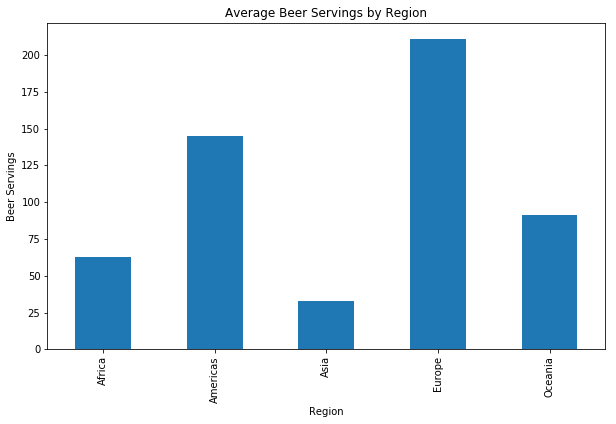

In [105]:
df.groupby('region').beer_servings.mean().plot(kind='bar', figsize=(10,6))
plt.title('Average Beer Servings by Region')
plt.xlabel('Region')
plt.ylabel('Beer Servings')
plt.show()

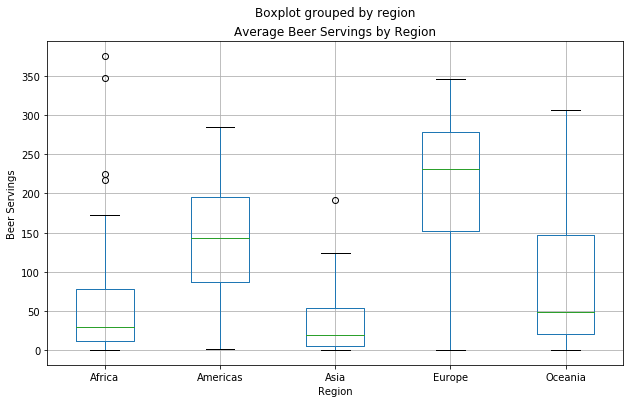

In [109]:
df.boxplot(column='beer_servings', by='region', figsize=(10,6))
plt.title('Average Beer Servings by Region')
plt.xlabel('Region')
plt.ylabel('Beer Servings')
plt.show()

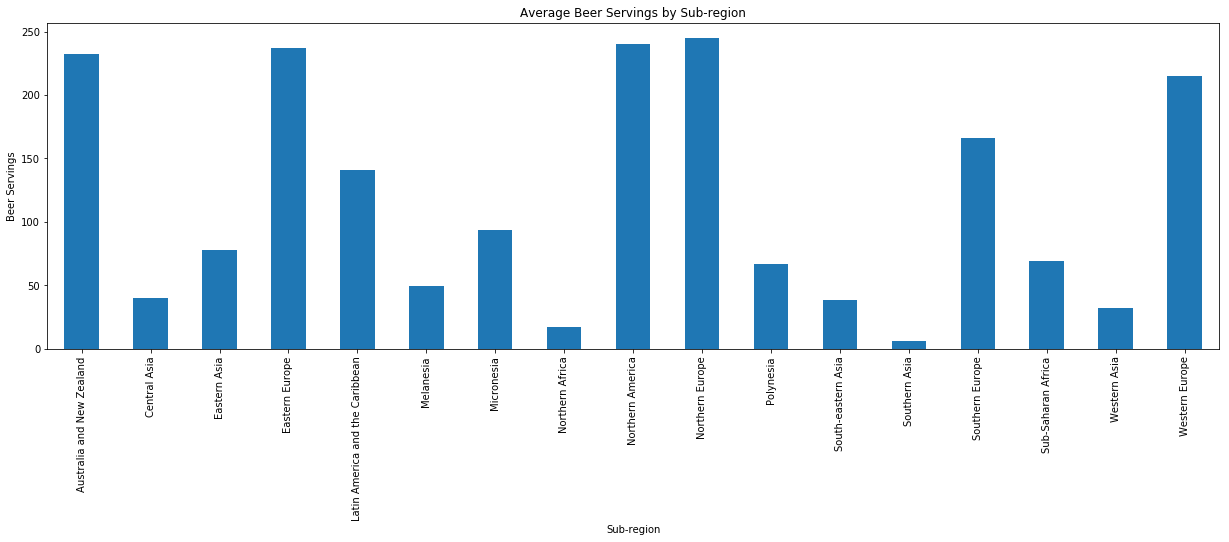

In [114]:
df.groupby('sub-region').beer_servings.mean().plot(kind='bar', figsize=(21,6))
plt.title('Average Beer Servings by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Beer Servings')
plt.show()

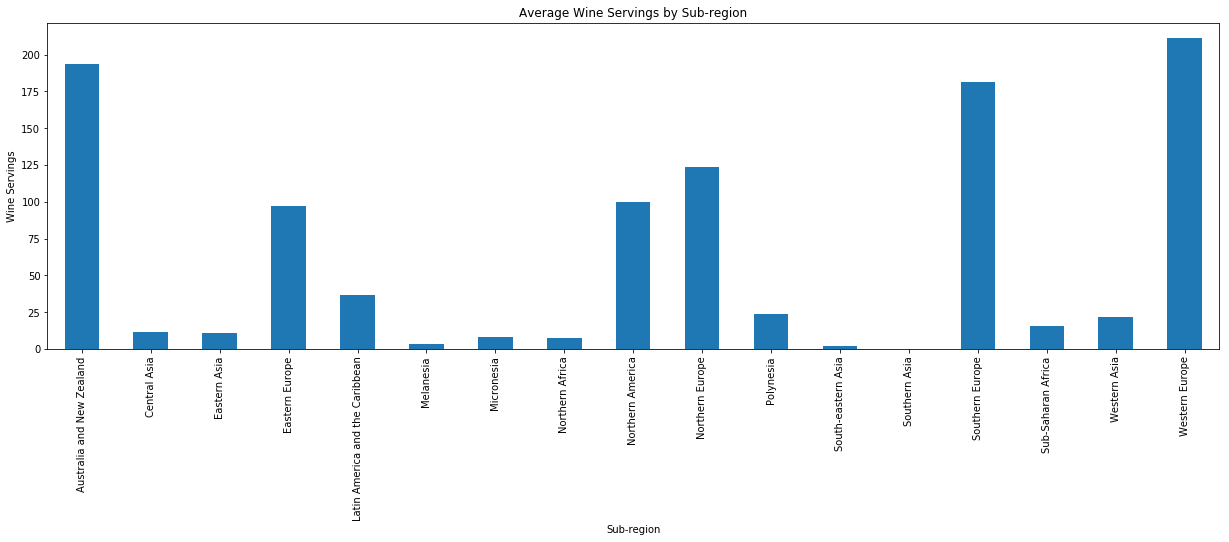

In [119]:
df.groupby('sub-region').wine_servings.mean().plot(kind='bar', figsize=(21,6))
plt.title('Average Wine Servings by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Wine Servings')
plt.show()

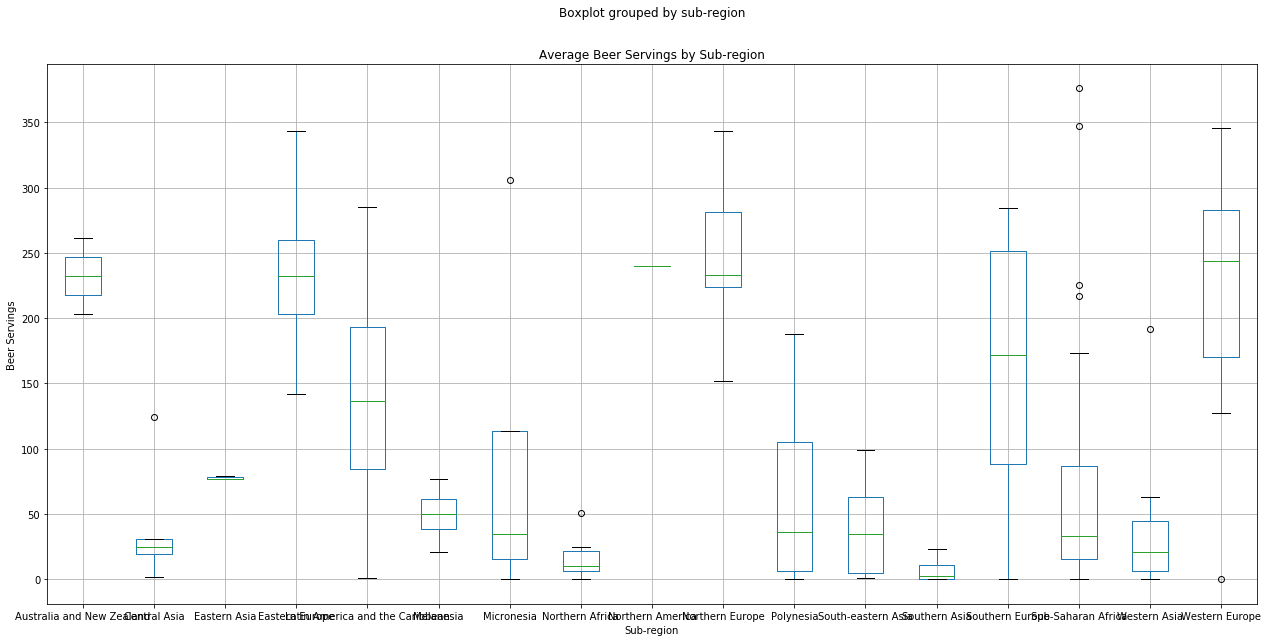

In [117]:
df.boxplot(column='beer_servings', by='sub-region', figsize=(21,10))
plt.title('Average Beer Servings by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Beer Servings')
plt.show()

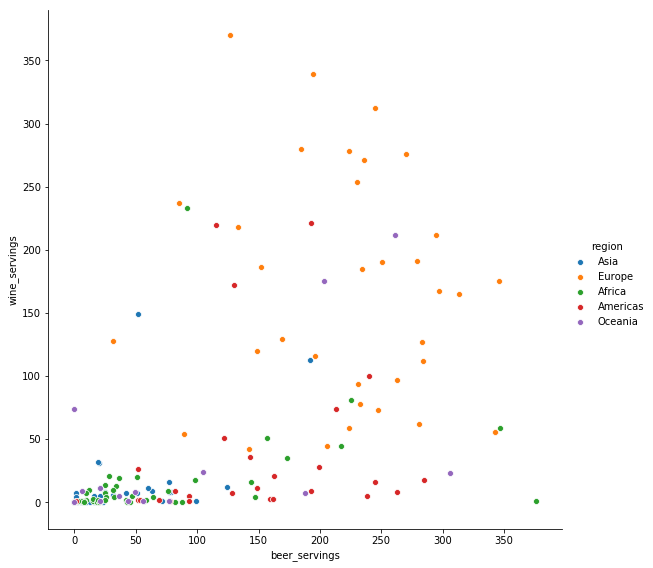

In [122]:
sns.pairplot(x_vars=['beer_servings'], y_vars=['wine_servings'], data=df, hue='region', height=8)
plt.show()

In [123]:
# Drop rows with NAs for Bokeh Interactive plot
df = df.dropna(subset=["region"])
df.shape

(167, 9)

In [124]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import d3
from bokeh.plotting import figure
from bokeh.transform import transform
output_notebook()

x = df.beer_servings.values
y = df.wine_servings.values
country = df.country
region = df.region

source = ColumnDataSource(data=dict(x=x, y=y, country=country, region=region))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('country', '@country'),
])

palette = d3['Category10'][len(df['region'].unique())]
mapper = CategoricalColorMapper(factors = df['region'].unique(), palette = palette)

# create figure and plot
p = figure(plot_width=600, plot_height=600, 
           tools=[hover, "wheel_zoom", "box_zoom", "reset"], 
           title="Beer and Wine Servings per Year by Country")

# create plot
p.scatter(x='x', y='y', size=10, alpha=0.8,
          color={'field': 'region', 'transform': mapper},
          legend='region', 
          source=source)

# add axis labels
p.xaxis.axis_label = "Beer Servings"
p.yaxis.axis_label = "Wine Servings"

output_file('interactive_bokeh_plot.html')
show(p)

Loading BokehJS ...

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.